# Link prediction with GCN

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our implementation of the [GCN](https://arxiv.org/abs/1609.02907) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GCN model that takes labeled node pairs (`citing-paper` -> `cited-paper`)  corresponding to possible citation links, and outputs a pair of node embeddings for the `citing-paper` and `cited-paper` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

## Creating the GCN link model

Next, we create the link generators for the train and test link examples to the model. The link generators take the pairs of nodes (`citing-paper`, `cited-paper`) that are given in the `.flow` method to the Keras model, together with the corresponding binary labels indicating whether those pairs represent true or false links.

The number of epochs for training the model:

In [8]:
epochs = 50

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method:

In [9]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [10]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.3` specifies a 30% dropout at each layer. 

We create a GCN model as follows:

In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

To create a Keras model we now expose the input and output tensors of the GCN model for link prediction, via the `GCN.in_out_tensors` method:

In [12]:
x_inp, x_out = gcn.in_out_tensors()

Final link classification layer that takes a pair of node embeddings produced by the GCN model, applies a binary operator to them to produce the corresponding link embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?LinkEmbedding` in it), and passes it through a dense layer:

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

The predictions need to be reshaped from `(X, 1)` to `(X,)` to match the shape of the targets we have supplied above.

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

Stack the GCN and prediction layers into a Keras model, and specify the loss

In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    # not just "acc" due to https://github.com/tensorflow/tensorflow/issues/41361
    metrics=["binary_accuracy"],
)

Evaluate the initial (untrained) model on the train and test set:

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 109ms/step - loss: 2.0672 - binary_accuracy: 0.5000
  ['...']
1/1 [==============================] - 0s 11ms/step - loss: 2.0854 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.0672
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.0854
	binary_accuracy: 0.5000


Train the model:

In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

  ['...']
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/50
1/1 - 1s - loss: 2.0177 - binary_accuracy: 0.5000 - val_loss: 0.6800 - val_binary_accuracy: 0.6282
Epoch 2/50
1/1 - 0s - loss: 0.7811 - binary_accuracy: 0.6148 - val_loss: 2.7203 - val_binary_accuracy: 0.5304
Epoch 3/50
1/1 - 0s - loss: 3.0683 - binary_accuracy: 0.5512 - val_loss: 0.8094 - val_binary_accuracy: 0.6070
Epoch 4/50
1/1 - 0s - loss: 1.0147 - binary_accuracy: 0.6281 - val_loss: 0.6638 - val_binary_accuracy: 0.6144
Epoch 5/50
1/1 - 0s - loss: 0.6450 - binary_accuracy: 0.6383 - val_loss: 0.7782 - val_binary_accuracy: 0.5452
Epoch 6/50
1/1 - 0s - loss: 0.7345 - binary_accuracy: 0.5594 - val_loss: 0.8198 - val_binary_accuracy: 0.5360
Epoch 7/50
1/1 - 0s - loss: 0.7581 - binary_accuracy: 0.5420 - val_loss: 0.7800 - val_binary_accuracy: 0.5424
Epoch 8/50
1/1 - 0s - loss: 0.7302 - binary_accuracy: 0.5635 - val_loss: 0.6993 - val_binary_accuracy: 0.5793
Epoch 9/50
1/1 - 0s - loss: 0.6579 - binary_accuracy: 0.6178

Plot the training history:

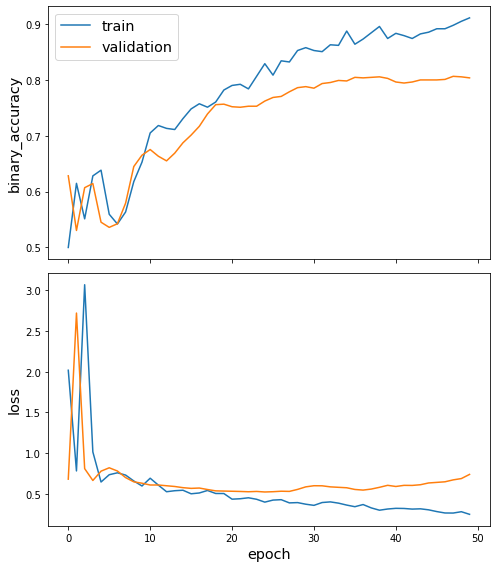

In [18]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
1/1 [==============================] - 0s 11ms/step - loss: 0.1937 - binary_accuracy: 0.9426
  ['...']
1/1 [==============================] - 0s 11ms/step - loss: 0.7384 - binary_accuracy: 0.8035

Train Set Metrics of the trained model:
	loss: 0.1937
	binary_accuracy: 0.9426

Test Set Metrics of the trained model:
	loss: 0.7384
	binary_accuracy: 0.8035


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>